In [9]:
from ext.raith21.fet import *
from srds import ParameterizedDistribution as PDist, BoundRejectionSampler, BufferedSampler
import sys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
devices = ['rpi3', 'rpi4', 'xeongpu', 'xeoncpu', 'nx', 'tx2', 'nano', 'rockpi', 'coral', 'nuc']
# basically resnet-inference, mobilenet-inference, speed_inference
# for each we get a min, a max, and the pdist.lognorm sampler. If a value is outside bounds it is discarded
workloads_list = ['faas-workloads/resnet-inference-gpu', 'faas-workloads/resnet-inference-cpu', 'faas-workloads/speech-inference-tflite', 'faas-workloads/mobilenet-inference-tflite', 'faas-workloads/mobilenet-inference-tpu']

In [7]:
fets = {
    k: BoundRejectionSampler(BufferedSampler(dist), xmin, xmax) for k, (xmin, xmax, dist) in
            ai_execution_time_distributions.items()
}

min_v, max_v, dist = ai_execution_time_distributions[('nuc', 'faas-workloads/speech-inference-tflite')]



In [12]:
dist.pdf(3)

2.768198706647144e-13

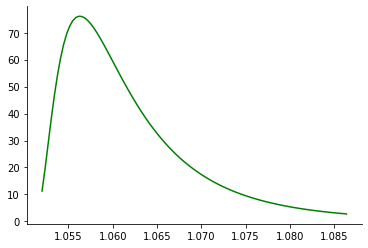

In [16]:


# 100 linearly spaced numbers
x = np.linspace(min_v,max_v,100)

# the function, which is y = x^3 here
y = dist.pdf(x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()



In [59]:
resnet_images = ['faas-workloads/resnet-inference-gpu', 'faas-workloads/resnet-inference-cpu']
mobilenet_images = ['faas-workloads/mobilenet-inference-tpu', 'faas-workloads/mobilenet-inference-tflite']
speech_images = ['faas-workloads/speech-inference-tflite']

def get_image_from_prio(device, image_list):
    for img in image_list:
        if (device, img) in ai_execution_time_distributions.keys():
            return img

devices = [('rpi3', 'RPi3'), ('rpi4', 'RPi4'), ('xeongpu', 'Xeon GPU'), ('xeoncpu', 'Xeon'), ('nx', 'Jetson Xavier NX'), ('tx2', 'Jetson TX2'), ('nano', 'Jetson Nano'), ('rockpi', 'RockPi'), ('coral', 'Coral'), ('nuc', 'Intel NUC')]
# devices = [('xeongpu', 'Xeon GPU'),('xeoncpu', 'Xeon'),('nx', 'Jetson Xavier NX')]
items = []
for (dev, friendly) in devices:
    resnet_img = get_image_from_prio(dev, resnet_images)
    mobilenet_img = get_image_from_prio(dev, mobilenet_images)
    speech_img = get_image_from_prio(dev, speech_images)
    items.append((dev, friendly, [resnet_img, mobilenet_img, speech_img]))

items

[('rpi3',
  'RPi3',
  ['faas-workloads/resnet-inference-cpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('rpi4',
  'RPi4',
  ['faas-workloads/resnet-inference-cpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('xeongpu',
  'Xeon GPU',
  ['faas-workloads/resnet-inference-gpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('xeoncpu',
  'Xeon',
  ['faas-workloads/resnet-inference-cpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('nx',
  'Jetson Xavier NX',
  ['faas-workloads/resnet-inference-gpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('tx2',
  'Jetson TX2',
  ['faas-workloads/resnet-inference-gpu',
   'faas-workloads/mobilenet-inference-tflite',
   'faas-workloads/speech-inference-tflite']),
 ('nano',
  'Jetson Nano',
  ['fa

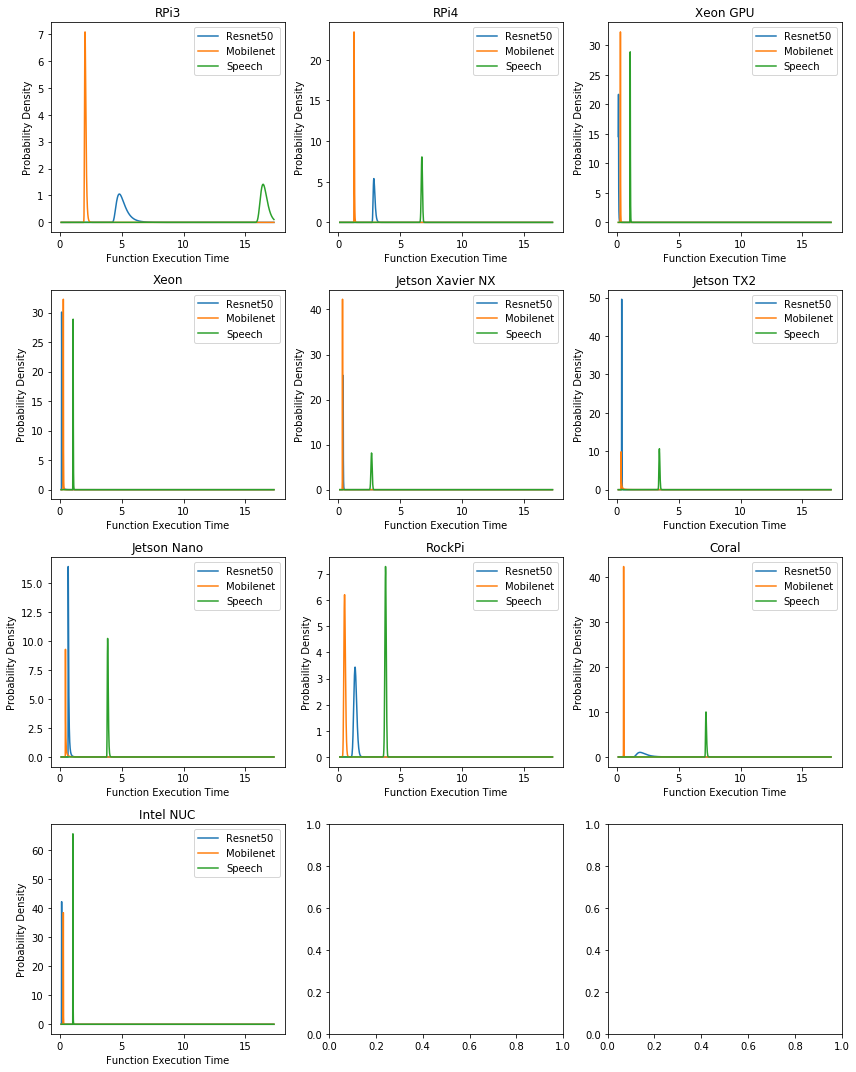

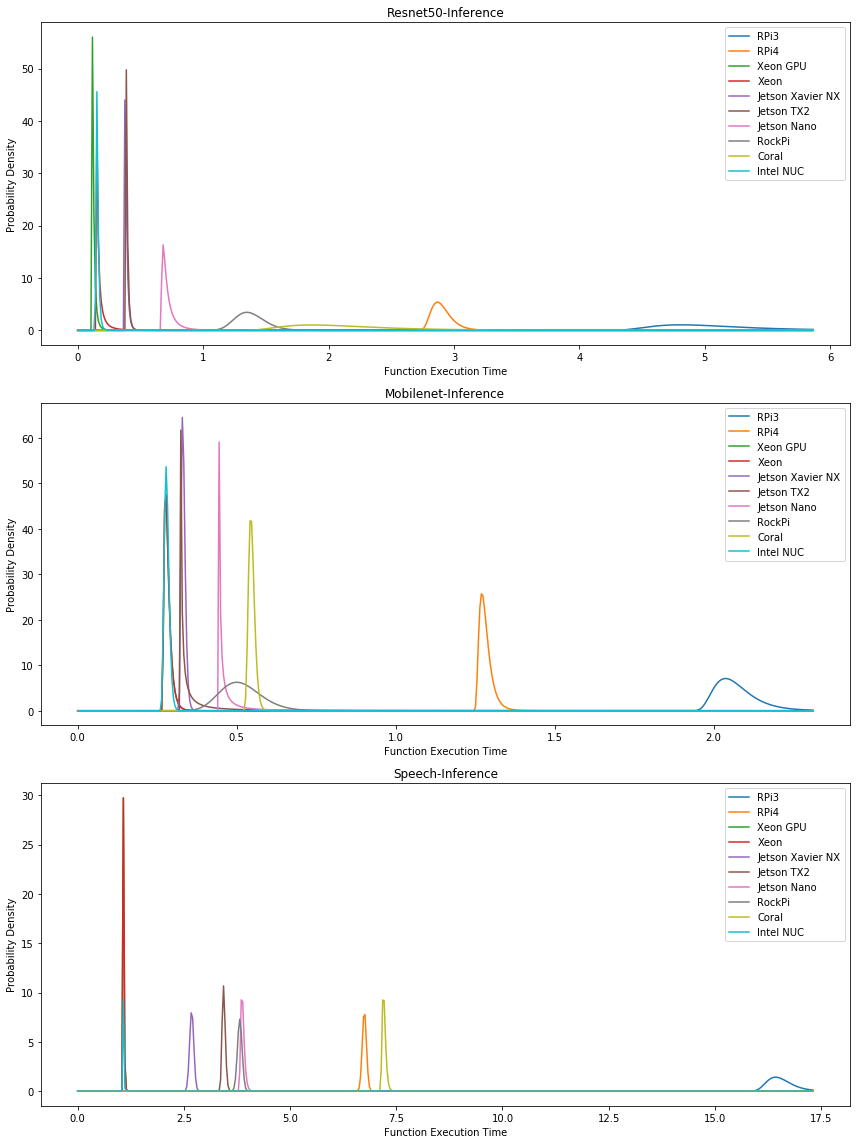

In [64]:
fig, axes = plt.subplots(4,3)
fig.set_figheight(15)
fig.set_figwidth(12)
axis_list = axes.reshape(-1)
image_friendlies = ['Resnet50', 'Mobilenet', 'Speech']

all_mins = []
all_maxs = []
for dev, _, images in items:
    for img in images:
        mn, mx, _ = ai_execution_time_distributions[(dev, img)]
        all_mins.append(mn)
        all_maxs.append(mx)
global_min = min(all_mins)
global_max = max(all_maxs)

#assumed order for images: resnet, mobile, speech
def plot_device(axis, device_name, friendly_name, images, fet_min, fet_max):
    axis.set_title(friendly_name)
    axis.set_xlabel('Function Execution Time')
    axis.set_ylabel('Probability Density')
#     axis.set_xlim((0, fet_max))
    r_min, r_max, r_dist = ai_execution_time_distributions[(device_name, images[0])]
    m_min, m_max, m_dist = ai_execution_time_distributions[(device_name, images[1])]
    s_min, s_max, s_dist = ai_execution_time_distributions[(device_name, images[2])]
    
    total_min = min(r_min, m_min, s_min)
    total_max = max(r_max, m_max, s_max)
    x = np.linspace(global_min, global_max, 1000)
    yr = r_dist.pdf(x)
    ym = m_dist.pdf(x)
    ys = s_dist.pdf(x)
    axis.plot(x, yr, label=image_friendlies[0])
    axis.plot(x, ym, label=image_friendlies[1])
    axis.plot(x, ys, label=image_friendlies[2])
    axis.legend(prop={'size': 10})
    

def plot_image(axis, image_friendly_name, image_index):
    axis.set_title(image_friendly_name)
    axis.set_xlabel('Function Execution Time')
    axis.set_ylabel('Probability Density')
    mins = []
    maxs = []
    friendlies = []
    dists = []
    for (dev, friendly, images) in items:
        mn, mx, dist = ai_execution_time_distributions[(dev, images[image_index])]
        mins.append(mn)
        maxs.append(mx)
        dists.append(dist)
        friendlies.append(friendly)
    t_min = min(mins)
    t_max = max(maxs)
    x = np.linspace(0, t_max, 500)
    
    for i, dist in enumerate(dists):
        axis.plot(x, dist.pdf(x), label=friendlies[i])
    axis.legend(loc='upper right')
    
for index, (dev, friendly, images) in enumerate(items):
    plot_device(axis_list[index], dev, friendly, images, 0, 3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3,1)
fig.set_figheight(16)
fig.set_figwidth(12)
axis_list = axes.reshape(-1)

image_friendlies = ['Resnet50-Inference', 'Mobilenet-Inference', 'Speech-Inference']

for i, friendly in enumerate(image_friendlies):
    plot_image(axis_list[i], friendly, i)
plt.tight_layout()
plt.show()


